In [7]:
import torch
from torch import nn
from torch.nn import functional as F
import numpy as np 
from matplotlib import pyplot as plt 
import time
import pandas as pd
import urllib.request



## The basic model

In [8]:
url = "https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt"
file_name = "tinyshakespare.txt"
urllib.request.urlretrieve(url,file_name)
lines=open(file_name, 'r').read()

vocab=sorted(list(set(lines)))

In [ ]:
#Python 스크립트는 지정된 URL에서 Tinyshakespeare 데이터 세트를 가져와서 "tinyshakespeare.txt"라는 파일 이름으로 로컬에 저장

In [9]:
DEFAULT_CONFIG={
    'd_model':128,
    'vocab_size':len(vocab),
    'batch_size':8,
    'context_window':16
}

In [10]:
#dataset 읽기
lines = open("tinyshakespare.txt", 'r').read()
vocab = sorted(list(set(lines)))
print('Printing the first 10 characters of the vocab list:', vocab[:10])
print('Total number of character in our dataset (Vocabulary Size):', len(vocab))

Printing the first 10 characters of the vocab list: ['\n', ' ', '!', '$', '&', "'", ',', '-', '.', '3']
Total number of character in our dataset (Vocabulary Size): 65


In [11]:
#mapping하기
#integers to characters(itos) and characters to integers(stoi)
itos={i: ch for i, ch in enumerate(vocab)}

stoi={ch: i for i, ch in enumerate(vocab)}

def encode(s):
    return [stoi[ch] for ch in s]

def decode(l):
    return ''.join(itos[i] for i in l)

decode(encode("morning"))

'morning'

In [12]:
#Encoding function
def encode(s):
    return [stoi[ch] for ch in s]
#Decode
def decode(l):
    return''.join([itos[i] for i in l])

#example
decode(encode("morning"))

'morning'

In [13]:
#pytorch 이용하기
dataset = torch.tensor(encode(lines), dtype=torch.int8)
print(dataset.shape)

torch.Size([1115394])


In [14]:
def get_batches(data, split, batch_size, context_window, config=DEFAULT_CONFIG):
    # 데이터셋을 훈련, 검증 및 테스트 세트로 분할
    train=data[:int(.8*len(data))]
    val=data[int(.8 * len(data)): int(.9*len(data))]
    test=data[int(.9 *len(data)):]
    
    # Determine whcih split to use
    batch_data=train
    if split=='val':
        batch_data=val
    if split=='test':
        batch_data=test
    
    # 어떤 분할을 사용할지 결정
    ix=torch.randint(0,batch_data.size(0)-context_window-1, (batch_size,))
    
    # 입력 시퀀스(x)와 해당하는 목표 시퀀스(y)를 생성
    x=torch.stack([batch_data[i:i+context_window] for i in ix]).long()
    y=torch.stack([batch_data[i+1:i+context_window+1] for i in ix]).long()
    
    return x,y

In [22]:
xs, ys=get_batches(dataset, 'train', DEFAULT_CONFIG['batch_size'], DEFAULT_CONFIG['context_window'])

decoded_samples=[(decode(xs[i].tolist()), decode(ys[i].tolist())) for i in range(len(xs))]

decoded_samples

[('y!\nMis-shapen ch', '!\nMis-shapen cha'),
 (' gifts, am bound', 'gifts, am bound '),
 ('hese articles.\n\n', 'ese articles.\n\nK'),
 ('ies. Nay, more,\n', 'es. Nay, more,\nS'),
 ('all not need tra', 'll not need tran'),
 ('ANUS:\nIt is apar', 'NUS:\nIt is apart'),
 ("s\nease:' O, an y", "\nease:' O, an yo"),
 ('sire;\nThou, bein', 'ire;\nThou, being')]

In [23]:
# LLaMA 아키텍처를 평가하는 전용함수를 만들 준비
# 학습반복 중에 모델의 성능을 평가-> 학습프로세스 중에 지속적인 평가를 가능하게 하기 위함

@torch.no_grad()
def evaluate_loss(model, config=DEFAULT_CONFIG):
    out={}
    
    model.eval()
    
    for split in ["train", "val"]:
        
        losses=[]
        
        for _ in range(10):
            xb,yb=get_batches(dataset, split, config['batch_size'], config['context_window'])
            _,loss=model(xb,yb)
            losses.append(loss.item())
            
        out[split]=np.mean(losses)
    model.train()
    
    return out

## RMSNorm for pre-normalization
초기화(initialization) 단계에서 이 클래스는 하나의 스케일 파라미터를 등록(register)한다.
 RMSNorm 클래스는 특정한 정규화 기법을 사용하여 입력을 조정하고, 이 조정된 값을 스케일 파라미터로 조절하여 반환하는 역할을 한다. 이러한 기능은 LLaMA에서 LayerNorm 작업을 대신하는데 사용된다.

In [24]:
class RMSNorm(nn.Module):
    def __init__(self, layer_shape, eps=1e-8, bias=False):
        super(RMSNorm, self).__init__()
        
        # scale이라는 학습가능한 매개변수를 모듈의 매개변수로 등록
        self.register_parameter('scale', nn.Parameter(torch.ones(layer_shape)))
    
    def forward(self,x):
        """
        Assumes shape is (batch, seq_len, d_model)
        """
        
        #Frobenius norm을 계산하고, RMS=1/sqrt(N)* Frobenius norm으로 정의
        ff_rms=torch.linalg.norm(x, dim=(1,2))*x[0].numel() ** -.5
        
        # 입력텐서 'x'를 RMS에 대해 정규화
        raw=x/ff_rms.unsqueeze(-1).unsqueeze(-1)
        
        # 정규화된 텐서를 학습 가능한 매개변수 scale을 사용하여 스케일링 한다.
        return self.scale[:x.shape[1],:].unsqueeze(0) * raw

In [25]:
class SimpleModel_RMS(nn.Module):
    def __init__(self, config=DEFAULT_CONFIG):
        super().__init__()
        self.config=config
        
        #문자 인덱스를 벡터로 변환하기 위한 임베딩 레이어를 생성
        self.embedding=nn.Embedding(config['vocab_size'], config['d_model'])
        
        #pre-normalization를 위한 RMSNorm layer
        self.rms=RMSNorm(config['context_window'], config['d_model'])
        
        #특성 간의 관계를 모델링하기 위한 선형 레이어
        self.linear=nn.Sequential(
            nn.Linear(config['d_model'], config['d_model']),
            nn.ReLU(),
            nn.Linear(config['d_model'], config['vocab_size']),
        )
    
    def forward(self, idx, targets=None):
        # 임베딩 레이어는 문자 인덱스를 벡터로 변환
        x =self.embedding(idx)
        
        # 특성 간의 관계를 모델링하기 위한 선형 레이어
        logits=self.linear(x)
        
        if targets is not None:
            loss=F.cross_entropy(logits.view(-1, self.config['vocab_size']), targets.view(-1))
            return logits, loss
        else:
            return logits

In [27]:
DEFAULT_CONFIG.update({
    'epochs': 1000,
    'log_interval':10,
    'batch_size':32,
})

model=SimpleModel_RMS(DEFAULT_CONFIG)

xs, ys=get_batches(dataset, 'train', DEFAULT_CONFIG['batch_size'], DEFAULT_CONFIG['context_window'])

logits, loss=model(xs, ys)

optimizer=torch.optim.Adam(model.parameters())

Validation loss: 2.5273885250091555


<Axes: >

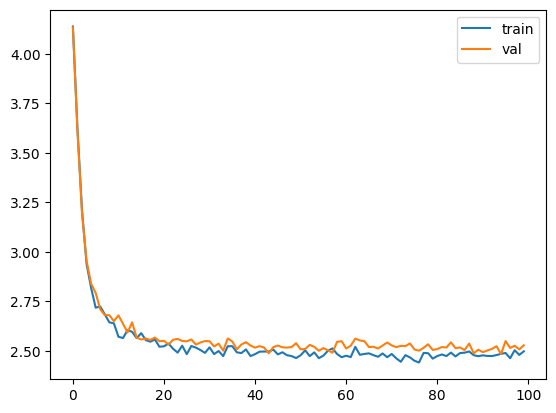

In [29]:
def train(model, optimizer, scheduler=None, config=DEFAULT_CONFIG, print_logs=False):
    losses=[]
    
    start_time=time.time()
    
    for epoch in range(config['epochs']):
        optimizer.zero_grad()
        
        xs, ys=get_batches(dataset, 'train', config['batch_size'], config['context_window'])
        
        logits, loss=model(xs, targets=ys)
        loss.backward()
        optimizer.step()
        
        if scheduler:
            scheduler.step()
        
        if epoch%config['log_interval']==0:
            batch_time=time.time()-start_time
            x=evaluate_loss(model)
            
            losses+=[x]
            
            if print_logs:
                print(f"Epoch {epoch} | val loss {x['val']:.3f}|Time {batch_time:.3f}|ETA in seconds{batch_time*(config['epochs']-epoch)/config['log_interval']:.3f}")
                
            start_time=time.time()
            
            if scheduler:
                print("lr: ", scheduler.get_lr())
    print("Validation loss:", losses[-1]['val'])
    
    return pd.DataFrame(losses).plot()

train(model, optimizer)

## Rotary Embeddings
RoPE에서는 시퀀스 내 토큰의 위치를 나타내기 위해 임베딩을 회전시키고 각 위치에서 다른 회전을 적용해야 한다. 
일반적으로 RoPE는 코사인(cosine) 및 사인(sine) 함수를 사용하여 각 위치에 대한 회전을 계산한다. 여기에 사용된 코사인 및 사인 값은 각 위치의 고유한 값을 기반으로 한다.

In [41]:
def get_rotary_matrix(context_window, embedding_dim):
    # 로터리 매트릭스를 초기화하고, 값은 모두 0으로 설정된 텐서를 생성
    R = torch.zeros((context_window, embedding_dim, embedding_dim), requires_grad=False)
    
    # 컨텍스트 창의 각 위치를 순회(loop)
    for position in range(context_window):
        # 임베딩의 각 차원을 순회(loop)
        for i in range(embedding_dim // 2):
            # 위치와 임베딩 차원을 기반으로 회전 각도(theta)를 계산
            theta = 10000. ** (-2. * (i - 1) / embedding_dim)
            # 사인과 코사인 함수를 사용하여 회전된 행렬 요소를 계산
            m_theta = position * theta
            R[position, 2 * i, 2 * i] = np.cos(m_theta)
            R[position, 2 * i, 2 * i + 1] = -np.sin(m_theta)
            R[position, 2 * i + 1, 2 * i] = np.sin(m_theta)
            R[position, 2 * i + 1, 2 * i + 1] = np.cos(m_theta)
    return R

## Masked Attention Head
트랜스포머 아키텍처에서는 어텐션 헤드(attention heads)를 사용
어텐션 헤드는 주어진 쿼리(Query), 키(Key), 밸류(Value)에 대해 어텐션 가중치를 계산한다. 마스킹된 어텐션은 주어진 위치 이전의 위치에 대한 정보를 사용하지 않도록 가리는데 사용한다.

In [42]:
class RoPEAttentionHead(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        # Linear transformation for query
        self.w_q = nn.Linear(config['d_model'], config['d_model'], bias=False)
        # Linear transformation for key
        self.w_k = nn.Linear(config['d_model'], config['d_model'], bias=False)
        # Linear transformation for value
        self.w_v = nn.Linear(config['d_model'], config['d_model'], bias=False)
        # Obtain rotary matrix for positional embeddings
        self.R = get_rotary_matrix(config['context_window'], config['d_model'])

    def get_rotary_matrix(context_window, embedding_dim):
        #RoPE(로터리 포지셔널 임베딩)를 위한 회전 매트릭스를 생성
        R = torch.zeros((context_window, embedding_dim, embedding_dim), requires_grad=False)
        for position in range(context_window):
            for i in range(embedding_dim//2):
                
                # Rest of the code
                ...

        return R

    def forward(self, x, return_attn_weights=False):
        # x: (배치, 시퀀스 길이, 차원) 형태의 입력 텐서

        b, m, d = x.shape  # batch size, sequence length, dimension

        # Q, K, 및 V에 대한 선형 변환
        q = self.w_q(x)
        k = self.w_k(x)
        v = self.w_v(x)

        # RoPE(로터리 포지셔널 임베딩) 매트릭스를 사용하여 Q와 K를 회전
        q_rotated = (torch.bmm(q.transpose(0, 1), self.R[:m])).transpose(0, 1)
        k_rotated = (torch.bmm(k.transpose(0, 1), self.R[:m])).transpose(0, 1)

        # 스케일링된 닷-프로덕트 어텐션 수행
        activations = F.scaled_dot_product_attention(
            q_rotated, k_rotated, v, dropout_p=0.1, is_causal=True
        )

        if return_attn_weights:
            # 어텐션 마스크 생성
            attn_mask = torch.tril(torch.ones((m, m)), diagonal=0)
            # 어텐션 가중치 계산 및 casual 마스크 추가
            attn_weights = torch.bmm(q_rotated, k_rotated.transpose(1, 2)) / np.sqrt(d) + attn_mask
            attn_weights = F.softmax(attn_weights, dim=-1)
            return activations, attn_weights

        return activations

## Multi-Head attention machanism

In [48]:
class RoPEMaskedMultiheadAttention(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config=config
        # RoPEMaskedAttentionHead 인스턴스의 목록을 attention heads로 생성
        self.heads=nn.ModuleList([
            RoPEAttentionHead(config) for _ in range(config['n_heads'])
        ])
        # Linear layer after concatenating heads
        self.linear=nn.Linear(config['n_heads']* config['d_model'], config['d_model'])
        self.dropout=nn.Dropout(.1) # Dropout layer
    
    def forward(self, x):
        # x: input tensor of shape (batch, sequence length, dimension)
        
        # 각 어텐션 헤드를 처리하고 결과를 연결
        heads=[h(x) for h in self.heads]
        x=torch.cat(heads, dim=-1)
        
        # 연결된 출력에 선형 변환 적용
        x=self.linear(x)
        
        # Apply dropout
        x=self.dropout(x)
        return x

In [49]:
DEFAULT_CONFIG.update({
    'n_heads':8
})

In [50]:
class RopeModel(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config

        # Embedding layer에 토큰 넣어주기
        self.embedding = nn.Embedding(config['vocab_size'], config['d_model'])
        
        # RMSNorm layer for pre-normalization
        self.rms = RMSNorm((config['context_window'], config['d_model']))
        
        # RoPEMaskedMultiheadAttention layer
        self.rope_attention = RoPEMaskedMultiheadAttention(config)

        # Linear layer followed by ReLU activation
        self.linear = nn.Sequential(
            nn.Linear(config['d_model'], config['d_model']),
            nn.ReLU(),
        )

        # Final linear layer 예측
        self.last_linear = nn.Linear(config['d_model'], config['vocab_size'])

        print("model params:", sum([m.numel() for m in self.parameters()]))

    def forward(self, idx, targets=None):
        # idx: input indices
        x = self.embedding(idx)

        # One block of attention
        x = self.rms(x)  # RMS pre-normalization
        x = x + self.rope_attention(x)

        x = self.rms(x)  # RMS pre-normalization
        x = x + self.linear(x)

        logits = self.last_linear(x)

        if targets is not None:
            loss = F.cross_entropy(logits.view(-1, self.config['vocab_size']), targets.view(-1))
            return logits, loss

        else:
            return logits

model params: 559681
Validation loss: 2.0644957304000853


<Axes: >

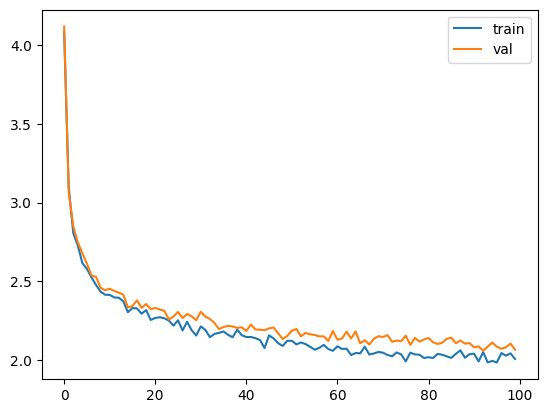

In [51]:
model=RopeModel(DEFAULT_CONFIG)

xs, ys=get_batches(dataset, 'train', DEFAULT_CONFIG['batch_size'], DEFAULT_CONFIG['context_window'])

logits, loss=model(xs, ys)

optimizer=torch.optim.Adam(model.parameters())

train(model, optimizer)
# 모델 파라미터는 559681이고 손실함수는 다음과 같다.